# Image Colorization using Optimization

## Imports

In [1]:
%matplotlib inline

import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

## Load Image

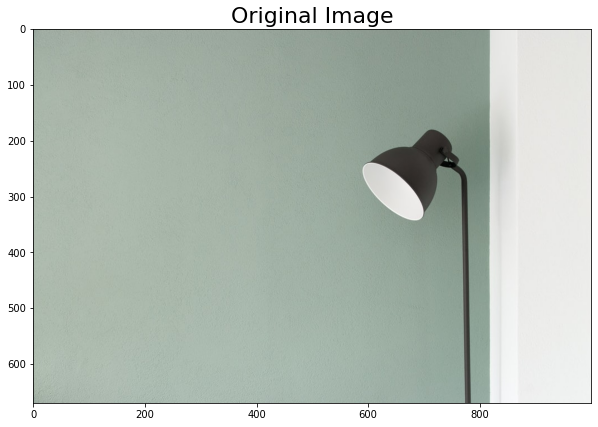

In [242]:
orig_img = cv2.cvtColor(cv2.imread("images/lamp.jpg"), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.title("Original Image", {'fontsize':22})
plt.imshow(orig_img)

## Convert to Grayscale

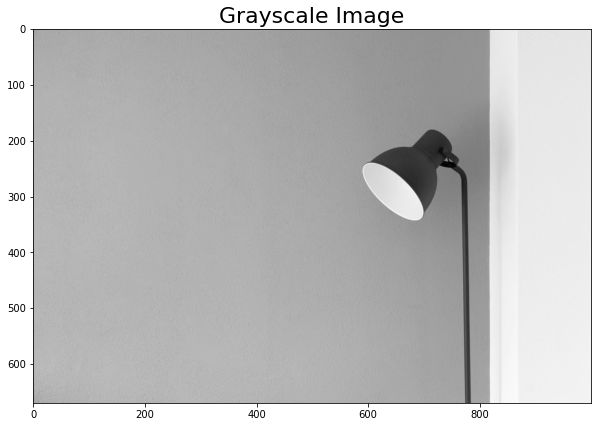

In [243]:
grayscale_img = cv2.cvtColor(orig_img, cv2.COLOR_RGB2GRAY)
plt.figure(figsize=(10, 10))
plt.title("Grayscale Image", {'fontsize':22})
plt.imshow(grayscale_img, cmap='gray')

## UI: Image Colorization Setup

### Step 1: Choose a color

In [379]:
from IPython import display
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual


color_picker = widgets.ColorPicker(
    concise=False,
    description='Pick a color',
    value='black',
    disabled=False
)
display.display(color_picker)

ColorPicker(value='black', description='Pick a color')

### Step 2: Place Markings

If it doesn't get you to the drawing mode, then rerun this function again.

============================================   NOTICE   ============================================

You do not need to rerun this cell or the last to add another color!
Simply select a new color from the color picker, press ENTER, and click on the figure to plot new colored points.


<IPython.core.display.Javascript object>


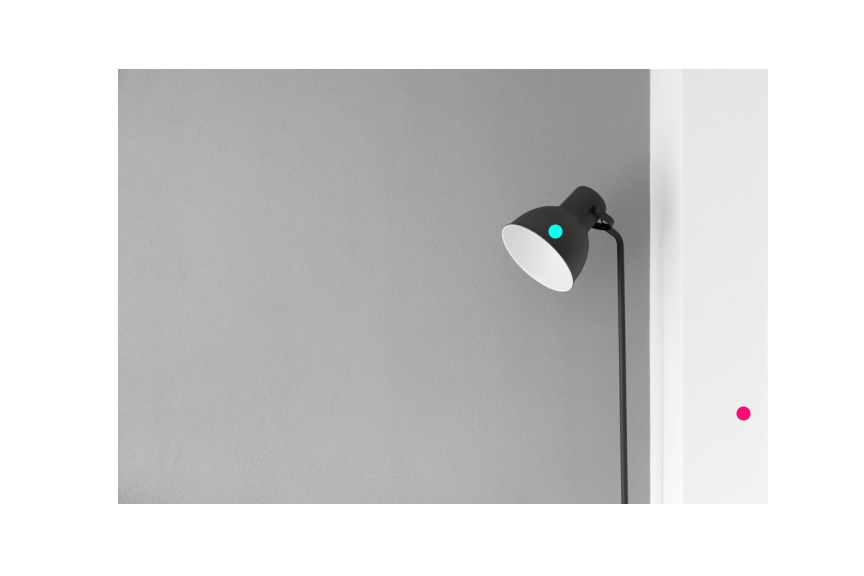

In [472]:
%matplotlib notebook

my_color = color_picker.value

def mark_image(img):
    print("If it doesn't get you to the drawing mode, then rerun this function again.")
    print("\n============================================   NOTICE   ============================================\n")
    print("You do not need to rerun this cell or the last to add another color!")
    print("Simply select a new color from the color picker, press ENTER, and click on the figure to plot new colored points.")
    fig = plt.figure()
    fig.set_label('Mark the spots to color')
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    plot_points = []

    def on_mouse_pressed(event):
        my_color = color_picker.value
        
        x = event.xdata
        y = event.ydata
        plot_points.append((x, y, my_color))
        plt.plot(x, y, c=my_color, marker='o')
        
    # Create an hard reference to the callback not to be cleared by the garbage
    # collector
    fig.canvas.mpl_connect('button_press_event', on_mouse_pressed)

    return plot_points

plot_points = mark_image(grayscale_img)

### Step 3: Add Markings to grayscale image

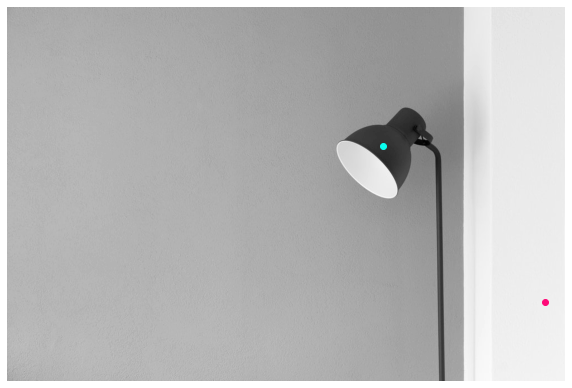

In [473]:
%matplotlib inline

colored_pixels = []

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(grayscale_img, cmap='gray')
for pt in plot_points:
    x, y, color = pt
    plt.plot(x, y, c=color, marker='o')
    colored_pixels.append((int(y), int(x)))
plt.savefig("output/marked_img.jpg", bbox_inches='tight', pad_inches=0, dpi=500)
marked_img = cv2.cvtColor(cv2.imread("output/marked_img.jpg"), cv2.COLOR_BGR2RGB)

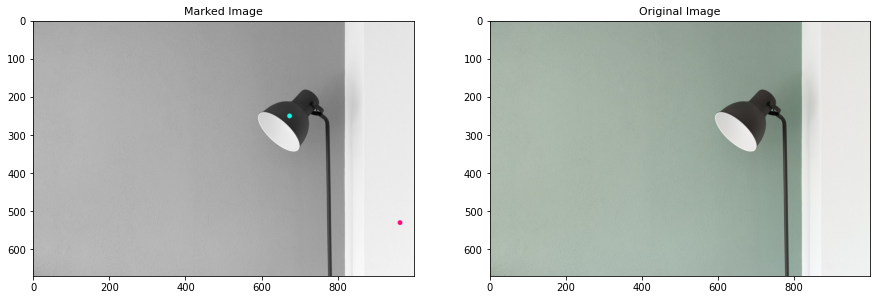

In [474]:
marked_img = cv2.resize(marked_img, (orig_img.shape[1], orig_img.shape[0]))

fig = plt.figure(figsize=(15, 15))
plt.subplot(122)
plt.title("Original Image", {'fontsize':11})
plt.imshow(orig_img)

plt.subplot(121)
plt.title("Marked Image", {'fontsize':11})
plt.imshow(marked_img)

### Step 5: Restore original intensity values for marked locations

Row 0
Row 50
Row 100
Row 150
Row 200
Row 250
Row 300
Row 350
Row 400
Row 450
Row 500
Row 550
Row 600
Row 650


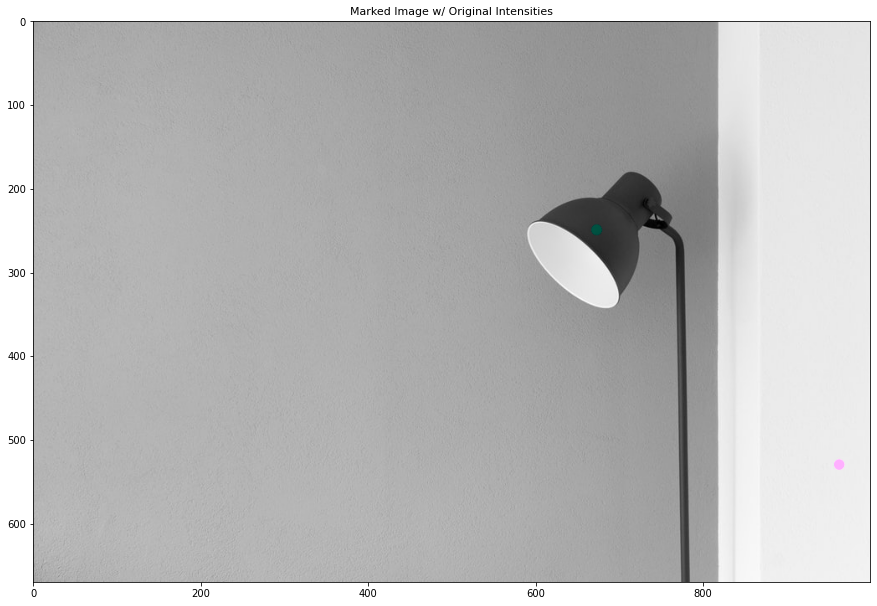

In [544]:
grayscale_yuv = cv2.cvtColor(grayscale_img, cv2.COLOR_GRAY2RGB)
grayscale_yuv = cv2.cvtColor(grayscale_yuv, cv2.COLOR_RGB2YUV)
yuv_image = cv2.cvtColor(marked_img, cv2.COLOR_BGR2YUV)



for row in range(yuv_image.shape[0]):
    if row % 50 == 0:
        print("Row " + str(row))
    for col in range(yuv_image.shape[1]):
        yuv_image[row, col, 0] = grayscale_yuv[row, col, 0]
        
fig = plt.figure(figsize=(15, 15))
plt.title("Marked Image w/ Original Intensities", {'fontsize':11})
plt.imshow(cv2.cvtColor(yuv_image, cv2.COLOR_YUV2BGR))
# plt.imshow(cv2.cvtColor(grayscale_yuv, cv2.COLOR_YUV2RGB))

In [548]:
def getWindowPixels(row, col):
    row_start = row - 1
    row_end = row + 2
    col_start = col - 1
    col_end = col + 2

    if row_start < 0:
        row_start = 0 
    if row_end >= height:
        row_end = height
    if col_start < 0:
        col_start = 0 
    if col_end >= width:
        col_end = width
    
    pixels = []
        
    for i in range(row_start, row_end):
        for j in range(col_start, col_end):
            if i != row or j != col:
                pixels.append((i, j))
                
    return pixels

### Step 6: Calculate the variances and means for each pixel window

In [522]:
variances = np.zeros((yuv_image.shape[0], yuv_image.shape[1]), dtype='uint8')
means = np.zeros(variances.shape, dtype='uint8')

height = variances.shape[0]
width = variances.shape[1]

# Calculate variances and mean for pixel windows
for row in range(height):
    if (row % 50 == 0):
        print("At row " + str(row))
    for col in range(width):       
        
        
        window = getWindowPixels(row, col)
        window_y_values = []
        
        for pixel in window:
            window_y_values.append(yuv_image[pixel[0], pixel[1]])
        
        variances[row, col] = np.var(window_y_values)
        means[row, col] = np.mean(window_y_values)
        

At row 0
At row 50
At row 100
At row 150
At row 200
At row 250
At row 300
At row 350
At row 400
At row 450
At row 500
At row 550
At row 600
At row 650


### Step 7: Use the variances and means to calculate the weights for each pixel

In [523]:
weights = {}

for row in range(height):
    if row % 50 == 0:
        print("Row: " + str(row))
    for col in range(width):
        neighboring_pixels = getWindowPixels(row, col)
        for pixel in neighboring_pixels:
            y_value = yuv_image[row, col, 0]
            
            weight = 1 + (1 / pow(variances[row, col], 2)) * (yuv_image[row, col, 0] - means[row, col]) * (yuv_image[row, col, 0] - means[pixel[0], pixel[1]])
            
            weights[((row, col), pixel)] = weight
            

Row: 0


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in ubyte_scalars
  # This is added back by InteractiveShellApp.init_path()


Row: 50
Row: 100
Row: 150


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


Row: 200
Row: 250
Row: 300
Row: 350
Row: 400
Row: 450
Row: 500
Row: 550
Row: 600
Row: 650


#### Step 7.b: Normalize the weights

In [524]:
for row in range(height):
    if row % 50 == 0:
        print("Row: " + str(row))
    for col in range(width):
        others = getWindowPixels(row, col)
        
        weightSum = 0
        
        for pixel in others:
            toAdd = weights[((row, col), (pixel[0], pixel[1]))]
            if math.isnan(toAdd):
                continue
            weightSum += weights[((row, col), (pixel[0], pixel[1]))]
            
        for pixel in others:
            weights[((row, col), (pixel[0], pixel[1]))] /= weightSum
            



Row: 0


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


Row: 50
Row: 100
Row: 150
Row: 200
Row: 250
Row: 300
Row: 350
Row: 400
Row: 450
Row: 500
Row: 550
Row: 600
Row: 650


In [525]:
# TESTING VALUES, DELETE LATER

# yuv_image = cv2.cvtColor(marked_img, cv2.COLOR_BGR2YUV)

# yuv_image[301, 645, 1] = 13
# yuv_image[301, 645, 2] = 13

# print(yuv_image[200, 700, 0])
# yuv_image[200, 700, 1] = 255
# yuv_image[200, 700, 2] = 255

for point in colored_pixels:
    window = getWindowPixels(point[0], point[1])
    
    for pixel in window:
            weight = weights[((point[0], point[1]), (pixel[0], pixel[1]))]
                
            variance_weights.append(weight)
            
    neighbor_variance = np.var(variance_weights)
    print(variance_weights)
    print(neighbor_variance)
    



[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.12499999999999997, 0.12499999999999997, 0.12499999999999997, 0.12499999999999997, 0.12499999999999997, 0.12499999999999997, 0.12499999999999997, 0.12499999999999997, 0.12500000000000003, 0.12500000000000003, 0.12500000000000003, 0.12500000000000003, 0.12500000000000003, 0.12500000000000003, 0.12500000000000003, 0.12500000000000003, 0.04117090821885163, 0.041526078450122086, 0.04170366356575732, 0.04170366356575732, 0.04170366356575732, 0.041526078450122086, 0.04170366356575732, 0.04170366356575732, 0.04170366356575732, 0.04170366356575732, 0.04170366356575732, 0.04170366356575732, 0.04170366356575732, 0.04170366356575732, 0.04170366356575732, 0.04170366356575732, 0.04170366356575732, 0.04170366356575732, 0.04170366356575732, 0.04170366356575732, 0.04170366356575732, 0.04170366356575732, 0.04170366356575732, 0.04170366356575732]
0.0017361176538343043
[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.12499999999999997, 0

### Step 8: Color areas

In [545]:
def traverseArea(start):
    toVisit = [start]
    visited = []
        
    while toVisit:
        point = toVisit.pop()
        
        if point in visited:
            continue
            
        visited.append(point)
        
        window = getWindowPixels(point[0], point[1])
    
        # Remove visited pixels
        for pixel in window:
            if pixel in visited:
                window.remove(pixel)

        minSize = 1 / len(getWindowPixels(point[0], point[1]))
        
        # Transfer color values
        variance_weights = []
        
        for pixel in window:
            weight = weights[((point[0], point[1]), (pixel[0], pixel[1]))]
                
            variance_weights.append(weight)
            
        neighbor_variance = np.var(variance_weights)
        
        for pixel in window:
            weight = weights[((point[0], point[1]), (pixel[0], pixel[1]))]
                

            if neighbor_variance < .0000004:
#                 print(neighbor_variance)
                yuv_image[pixel[0], pixel[1], 1] = yuv_image[point[0], point[1], 1]
                yuv_image[pixel[0], pixel[1], 2] = yuv_image[point[0], point[1], 2]
                toVisit.append(pixel) 
            
    
            if weight >= .80:
                print(weight)
                print("HERE")
                yuv_image[pixel[0], pixel[1], 1] = yuv_image[point[0], point[1], 1]
                yuv_image[pixel[0], pixel[1], 2] = yuv_image[point[0], point[1], 2]
                toVisit.append(pixel)  




start = (238, 639)
# traverseArea((200, 700))

In [546]:
for pixel in colored_pixels:
    print(pixel)
    print("new color call")
    traverseArea(pixel)
    


(248, 672)
new color call


KeyboardInterrupt: 

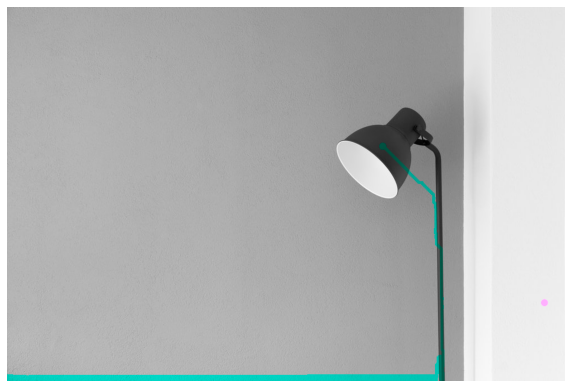

In [547]:
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(cv2.cvtColor(yuv_image, cv2.COLOR_YUV2BGR))


In [191]:
print(yuv_image[250, 171])

[163 128 128]
